# HW3
각 사례에서 overfitting 해결하기!
> 모수초기치, 활성함수, dropout, 노스 수나 커널사이즈 조절, vgg inputsize 규제화, normalization

## 1) Dog/Cat Classification Data
> 이전학습 + 자료증대(No fine tuning)

- target size(vgg input size) 150>100 조절
- dropout, initialization 추가
- 노드의 개수 256에서 64개로 줄임
- L1 규제화 추가
- callbacks 추가

In [30]:
# 관련 이미지가 들어있는 디렉토리 지정
train_dir = '/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/dogs and cats_small/train'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/dogs and cats_small/validation'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/dogs and cats_small/test'

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=40, width_shift_range=0.2, 
                               height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                horizontal_flip=True, fill_mode='nearest')    # augmentation > error 추가small/validation'
                                                                                         
test_datagen=ImageDataGenerator(rescale=1./255)   ## 뒤에서는 이 부분에 augmentation을 한다!

# .flow_from_directory를 이용 
train_generator=train_datagen.flow_from_directory(directory=train_dir,target_size=(100,100),
                                                  batch_size=20,class_mode='binary')
validation_generator=test_datagen.flow_from_directory(directory=validation_dir,target_size=(100,100),
                                                      batch_size=20,class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


In [31]:
from tensorflow.keras.applications import VGG16  # 파라미터 freeze
vgg_base=VGG16(weights='imagenet',include_top=False, input_shape=(100,100,3)) 
vgg_base.summary()  # 이미 training 되어있음

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
model_aug=Sequential()

######### 우선 vgg 구조를 모델에 추가하기 ######
model_aug.add(vgg_base)  # 여기에 아예 집어넣음 >> 근데 여기 파라미터는 freez 시켜야함.(아니면 2000개의 파라미터를 가지고 1400만개의 파라미터를 추정하는 꼴이 됨) 그럼 위 과정과 완전히 같아진다. 
model_aug.add(Flatten())
model_aug.add(Dense(64,activation='relu', kernel_initializer='he_normal'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(1,activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(0.01)))  # 드랍아웃을 안했기때문에 위 결과보다 나쁠수밖에 없음. 
model_aug.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                294976    
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 15,009,729
Trainable params: 15,009,729
Non-trainable params: 0
_________________________________________________________________


In [38]:
from tensorflow.keras import optimizers

# callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
callback_list = [EarlyStopping(monitor='acc', patience=2),   
                 ModelCheckpoint(filepath='model_ch5', monitor='val_acc', save_best_only='True')]

model_aug.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
model_aug_result=model_aug.fit_generator(train_generator,
                                         steps_per_epoch=100,   # 100개의 배치를 사용
                                         epochs=10, 
                                         validation_data=validation_generator,
                                         validation_steps=50, callbacks=callback_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 21s 187ms/step - loss: 0.5754 - acc: 0.7615 - val_loss: 0.4725 - val_acc: 0.8420
INFO:tensorflow:Assets written to: model_ch5/assets
Epoch 2/10
100/100 [==============================] - 19s 190ms/step - loss: 0.4478 - acc: 0.8466 - val_loss: 0.3119 - val_acc: 0.9130
INFO:tensorflow:Assets written to: model_ch5/assets
Epoch 3/10
100/100 [==============================] - 18s 184ms/step - loss: 0.3693 - acc: 0.8936 - val_loss: 0.3003 - val_acc: 0.9080
Epoch 4/10
100/100 [==============================] - 18s 183ms/step - loss: 0.3258 - acc: 0.9061 - val_loss: 0.3530 - val_acc: 0.9020
Epoch 5/10
100/100 [==============================] - 18s 184ms/step - loss: 0.3424 - acc: 0.9088 - val_loss: 0.2554 - val_acc: 0.9370
INFO:tensorflow:Assets written to: model_ch5/assets
Epoch 6/10
100/100 [==============================] - 18s 184ms/step - loss: 0.2949 - acc: 0.9218 - val_loss: 0.3040 - val_acc: 0.9170
Epoch 7/10
100/100 [==============

In [43]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(test_dir,target_size=(100,100),
                                              batch_size=20, class_mode='binary')

Found 1000 images belonging to 2 classes.


In [46]:
loss, acc=model_aug.evaluate(test_generator,steps=50)  # 배치가20이므로 step size 1000

50/50 [==============================] - 4s 83ms/step - loss: 0.3211 - acc: 0.9270


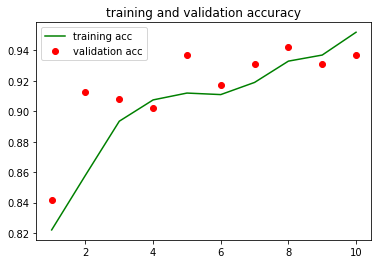

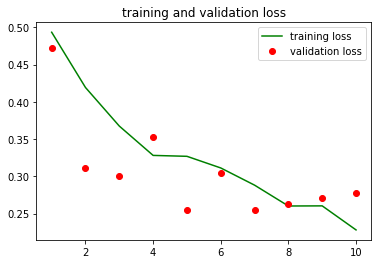

In [50]:
import matplotlib.pyplot as plt
acc=model_aug_result.history['acc']
val_acc=model_aug_result.history['val_acc']
loss=model_aug_result.history['loss']
val_loss=model_aug_result.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='training acc')
plt.plot(epochs,val_acc,'ro',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

## 2) Gender Classification Data
> Simple 전이학습

In [1]:
import pandas as pd 
from skimage import io   # 이미지 read
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense, Dropout
from tensorflow.keras.models import Sequential

data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/gender_data.csv')  
data.head(2)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42


In [2]:
data.shape

(64084, 10)

In [3]:
# 남녀 동등하게 1000개만 뽑아서 학습 > 1500개로 늘림
data_male=data[data['please_select_the_gender_of_the_person_in_the_picture']=='male']
data_female=data[data['please_select_the_gender_of_the_person_in_the_picture']=='female']
final_data=pd.concat([data_male[:1500],data_female[:1500]], axis=0).reset_index(drop=True) 

In [4]:
final_data.shape

(3000, 10)

In [5]:
# 이미지 load(url로 연결되어있음)
from tqdm import tqdm
x=[]
y=[]
for i in tqdm(range(final_data.shape[0])):
    try:
        image=io.imread(final_data.loc[i]['image_url'])
        if (image.shape==(300,300,3)): 
            x.append(image)
            y.append(final_data.loc[i]['please_select_the_gender_of_the_person_in_the_picture'])
    except:
        continue

100%|██████████| 3000/3000 [22:29<00:00,  2.22it/s]


In [12]:
print(len(x), len(y))  # 3000개 중 2598개만 걸러냄

2598 2598


In [45]:
# Resize
x2=[]
y2=[]
for i in range(len(x)):  # 1760개의 data
    img2=cv2.resize(x[i],(50,50))   # cv로 50,50으로 resize, 채널은 3이 디폴트
    x2.append(img2)
    img_label=np.where(y[i]=='male',1,0)  # 남성이면 1, 아니면 0으로 one-hot으로 바꿔줌
    y2.append(img_label)

In [46]:
# 텐서(array 형태)로 변환
x2=np.array(x2)  # tensor에서 numpy data로 고쳐줌

x1=x2.astype('float32')/255.
y1=np.array(y2)
print(x1.shape, y1.shape)  # train, test data

(2598, 50, 50, 3) (2598,)


In [47]:
# split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x1,y1,test_size=0.2,random_state=1, stratify=y)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(2078, 50, 50, 3) (520, 50, 50, 3) (2078,) (520,)


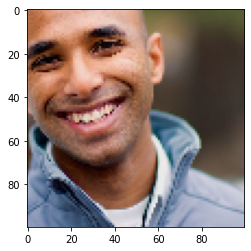

In [33]:
plt.imshow(x_train[27])
plt.show()  # 50*50 사이즈의 RGB(채널 3)로 이루어진 사진

In [48]:
# Pretrained VGG16
from tensorflow.keras.applications import VGG16   # input 줄여봄
vgg16_model=VGG16(weights='imagenet',include_top=False,input_shape=(300,300,3))  # input size는 내 마음대로 조절 
vgg16_model.summary()  

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [50]:
x1[1].shape

(50, 50, 3)

In [52]:
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tqdm.notebook import tqdm

x5_vgg16=[]  # vgg가 predict한 값 저장
y5=[]

for i in tqdm(range(len(x))):
    img=x[i]
    img=preprocess_input(img.reshape(1,300,300,3))  # reshape : 맨 앞에 1을 집어 넣음 > 4d 텐서 전환
    img_new=vgg16_model.predict(img)  # vgg가 앞선 input을 학습하도록 함
    x5_vgg16.append(img_new) 

    img_label=np.where(y[i]=='male',1,0)
    y5.append(img_label)

In [55]:
# reshape
x5_vgg16=np.array(x5_vgg16)
print(x5_vgg16.shape)  # 불필요한 1이 존재하는 모습이다
x5_vgg16=x5_vgg16.reshape(x5_vgg16.shape[0],x5_vgg16.shape[2],x5_vgg16.shape[3],x5_vgg16.shape[4])  # reshape
print(x5_vgg16.shape)  
y5=np.array(y5)  ## 이거 대신 tf.squeeze를 써도됨

(2598, 1, 9, 9, 512)
(2598, 9, 9, 512)


In [56]:
# 한번 더 split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x5_vgg16,y5,test_size=0.1,random_state=1, stratify=y5)
## vgg 출력값이 X, label은 y
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2338, 9, 9, 512) (2338,) (260, 9, 9, 512) (260,)


In [71]:
import tensorflow as tf
modelvgg16=Sequential()
modelvgg16.add(Conv2D(64,(3,3),activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), kernel_initializer='he_normal'))
# # VGG 마지막 채널 수 512 맞춰주기
# modelvgg16.add(MaxPooling2D((2,2)))

# MLP 층
modelvgg16.add(Flatten())
modelvgg16.add(Dense(32,activation='relu', kernel_initializer='he_normal'))
modelvgg16.add(Dropout(0.8))   # dropout 추가
modelvgg16.add(Dense(1,activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(0.03)))
modelvgg16.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 7, 7, 64)          294976    
_________________________________________________________________
flatten_10 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                100384    
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 395,393
Trainable params: 395,393
Non-trainable params: 0
_________________________________________________________________


In [72]:
modelvgg16.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_vgg16=modelvgg16.fit(x_train/np.max(x_train), y_train,batch_size=32, epochs=20, validation_data=(x_test/np.max(x_train),y_test))

Epoch 1/20
74/74 [==============================] - 1s 8ms/step - loss: 0.8571 - accuracy: 0.5870 - val_loss: 0.5123 - val_accuracy: 0.9000
Epoch 2/20
74/74 [==============================] - 0s 5ms/step - loss: 0.5755 - accuracy: 0.8218 - val_loss: 0.3967 - val_accuracy: 0.9269
Epoch 3/20
74/74 [==============================] - 0s 5ms/step - loss: 0.4756 - accuracy: 0.8667 - val_loss: 0.3108 - val_accuracy: 0.9423
Epoch 4/20
74/74 [==============================] - 0s 5ms/step - loss: 0.4180 - accuracy: 0.8839 - val_loss: 0.2885 - val_accuracy: 0.9269
Epoch 5/20
74/74 [==============================] - 0s 5ms/step - loss: 0.3849 - accuracy: 0.8739 - val_loss: 0.2699 - val_accuracy: 0.9269
Epoch 6/20
74/74 [==============================] - 0s 5ms/step - loss: 0.3262 - accuracy: 0.9196 - val_loss: 0.2574 - val_accuracy: 0.9231
Epoch 7/20
74/74 [==============================] - 0s 5ms/step - loss: 0.3155 - accuracy: 0.9061 - val_loss: 0.2480 - val_accuracy: 0.9308
Epoch 8/20
74/74 [==

In [76]:
score=modelvgg16.evaluate(x_test,y_test)  # 모수가 100개이기 때문에 보나마나 오버피팅
print(score)

9/9 [==============================] - 0s 3ms/step - loss: 100.9341 - accuracy: 0.9115
[100.93408203125, 0.9115384817123413]


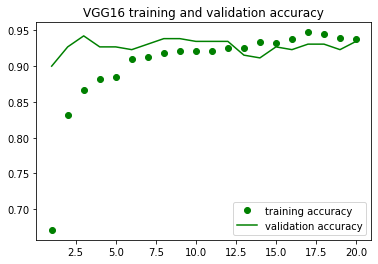

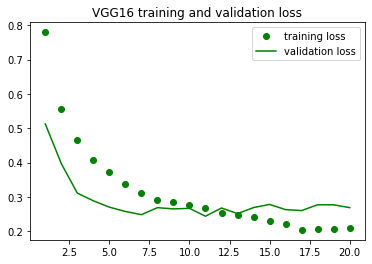

In [73]:
import matplotlib.pyplot as plt
acc=history_vgg16.history['accuracy']
val_acc=history_vgg16.history['val_accuracy']
loss=history_vgg16.history['loss']
val_loss=history_vgg16.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'go',label='training accuracy')
plt.plot(epochs, val_acc,'g',label='validation accuracy')
plt.title('VGG16 training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'go',label='training loss')
plt.plot(epochs, val_loss,'g',label='validation loss')
plt.title('VGG16 training and validation loss')
plt.legend()
plt.show()